# Імпортуємо бібліотеки та датасет

In [1]:
### Essential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
### Tools
import warnings
import gc
from tqdm import tqdm
from joblib import dump, load
### ML
import sklearn 
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import KFold
## Config
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
pd.options.plotting.backend = "plotly"
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', font_scale=1.4)
sns.set_palette('crest')
px.defaults.color_continuous_scale='blugrn'


In [2]:
data = pd.read_csv("data/data.zip")
data,test = train_test_split(data,test_size=0.05,shuffle=True,random_state=0)
test.to_csv('data/test.csv',index=False)
data.reset_index(drop=True)
# transform date
data.install_date = pd.to_datetime(data.install_date)

Усього навсього 5474 nan-ів. Одразу видалимо через їх малу кількість

In [3]:
print("NAN count: ", data.isna().astype(int).sum().sum())
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)

NAN count:  5160


In [4]:
data.head()

total_sessions_day0  total_sessions_day1  total_sessions_day3  \
0               1.0000               1.0000               1.0000   
1               2.0000               2.0000               2.0000   
2               2.0000               2.0000               3.0000   
3               1.0000               1.0000               1.0000   
4               1.0000               1.0000               1.0000   

   total_sessions_day7  chapters_finished_day0  chapters_finished_day1  \
0               1.0000                       1                       1   
1               2.0000                       0                       0   
2               3.0000                       3                       3   
3               1.0000                       2                       2   
4               1.0000                       0                       0   

   chapters_finished_day3  chapters_finished_day7  chapters_opened_day0  \
0                       1                       1                     2   
1                       0                       0                     1   
2                       5                       5                     4   
3                       2                       2                     2   
4                       0                       0                     1   

   chapters_opened_day1  chapters_opened_day3  chapters_opened_day7  \
0                     2                     2                     2   
1                     1                     1                     1   
2                     4                     6                     6   
3                     2                     2                     2   
4                     1                     1                     1   

   chapters_closed_day0  chapters_closed_day1  chapters_closed_day3  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   chapters_closed_day7  diamonds_received_day0  diamonds_received_day1  \
0                     0                      22                      22   
1                     0                      20                      20   
2                     0                      31                      31   
3                     0                      29                      29   
4                     0                      20                      20   

   diamonds_received_day3  diamonds_received_day7  diamonds_spent_day0  \
0                      22                      22                   12   
1                      20                      20                    0   
2                      37                      37                   24   
3                      29                      29                   12   
4                      20                      20                   12   

   diamonds_spent_day1  diamonds_spent_day3  diamonds_spent_day7  \
0                   12                   12                   12   
1                    0                    0                    0   
2                   24                   24                   24   
3                   12                   12                   12   
4                   12                   12                   12   

   tickets_spent_day0  tickets_spent_day1  tickets_spent_day3  \
0                   1                   1                   1   
1                   0                   0                   0   
2                   3                   3                   5   
3                   1                   1                   1   
4                   0                   0                   0   

   tickets_spent_day7  retained_day1  retained_day3  retained_day7  \
0                   1              0              0              0   
1       

Можна змінити тип даних и зменшити обсяг зайнятої пам'яті майже на 50%

In [5]:
start_mem = data.memory_usage().sum() / 1024**2 
for col in data.columns:
    if data[col].dtype=='int64':
        data[col] = data[col].astype(np.int32)
    if data[col].dtype=='float64':
        data[col] = data[col].astype(np.float32)
end_mem = data.memory_usage().sum() / 1024**2

print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

Mem. usage decreased to 356.07 Mb (46.8% reduction)


При огляді даних я помітив декілька від'ємних значень. Видалимо їх

In [6]:
numerical_cols = [col for col in data.columns if data[col].dtype in ['float32','int32']]
print('Total negative values', (data[numerical_cols]<0).astype(int).sum().sum() )
print('Size before: ', data.shape[0])
for col in numerical_cols:
    data.drop(data[data[col]<0].index,inplace=True)
print('Size after: ', data.shape[0])

Total negative values 19
Size before:  1393145
Size after:  1393141


# Огляд датасету

Бачимо у даних велику кількість нулів і ключова фіча target_full_ltv_day30 не виключення, вона на 76% складається з нулів. 

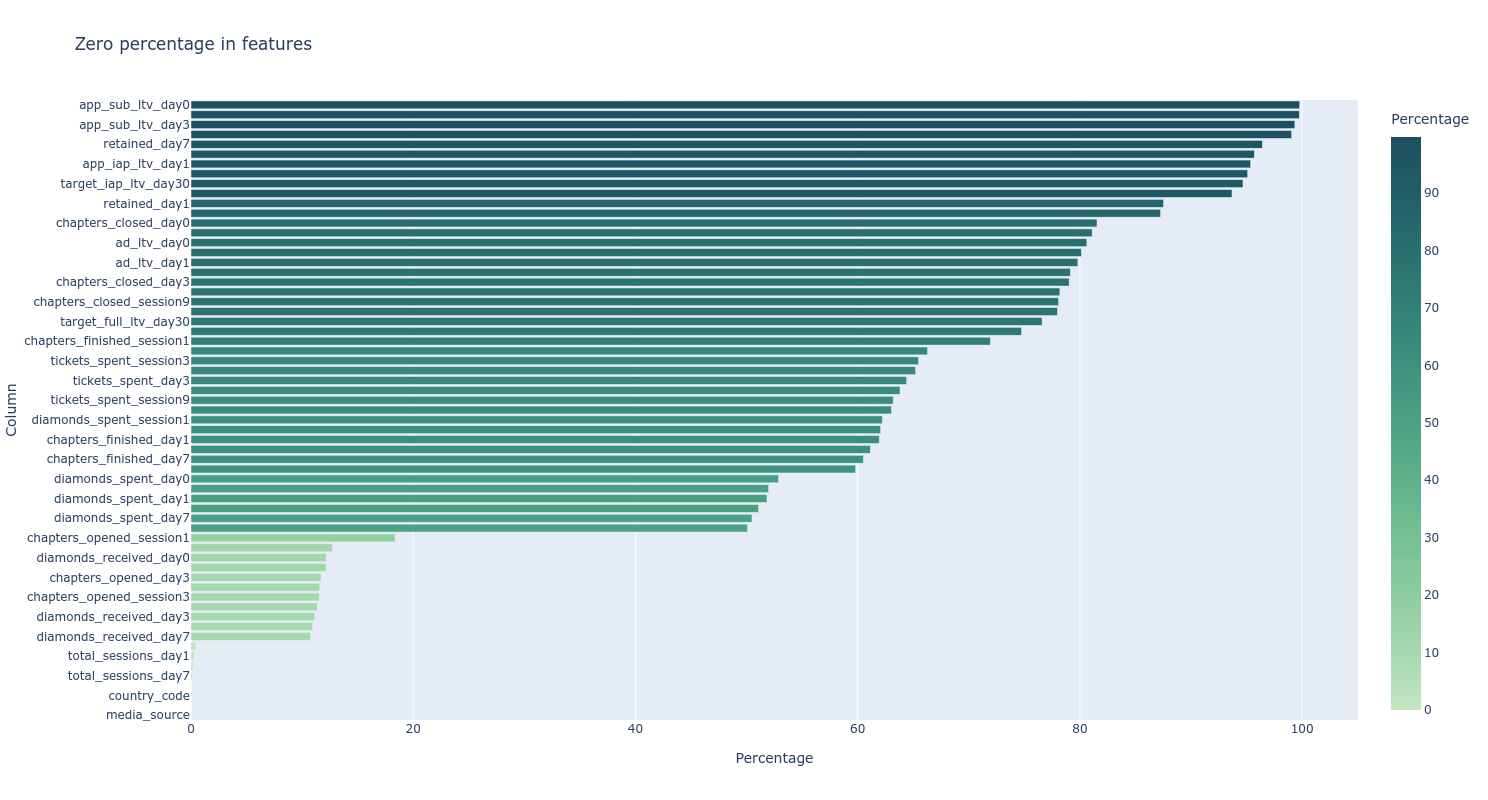

In [7]:
zero_counts = (data==0).astype(int).sum(axis=0)\
.apply(lambda row: np.round(row/data.shape[0],4)*100)\
.reset_index()\
.rename({'index':'Column',0:'Percentage'},axis=1)

px.bar(zero_counts.sort_values(by='Percentage'),y='Column',x='Percentage',orientation='h',height=800,color='Percentage',title='Zero percentage in features')

## media_source

In [8]:
def unique_categories(df,col):
    print(f'Unique categories in {col}: {len(data[col].unique())}')

In [9]:
unique_categories(data,'media_source')

Unique categories in media_source: 24


Бачимо, що хоч якийсь відсоток є лише у 10 категорій, тому усі інші замінимо на спільну категорію NOT_COMMON

In [10]:
top_sources = data.media_source.value_counts().iloc[:20]

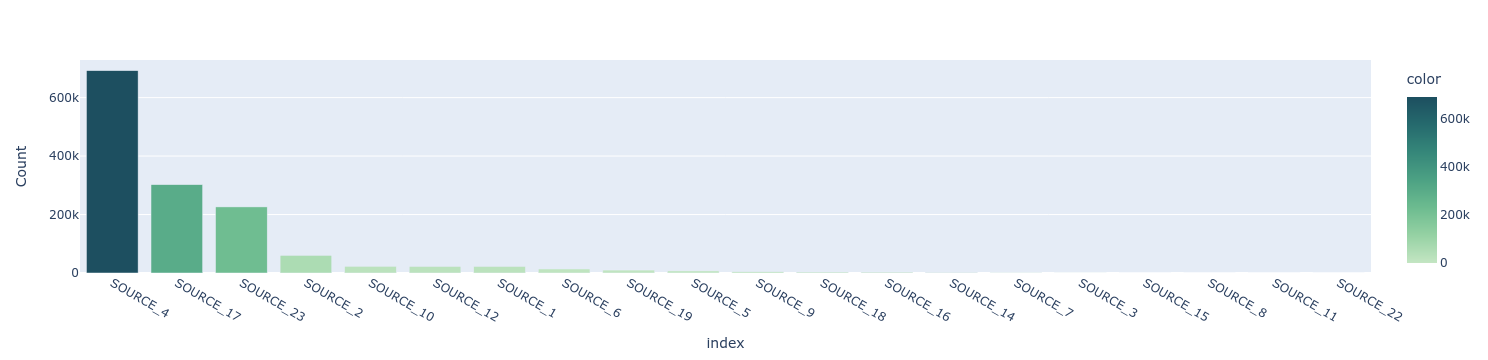

In [11]:
top_sources.plot.bar(color = top_sources).update_layout(yaxis_title="Count")

In [12]:
data['media_source'] = data.media_source.apply(lambda source: source if source in top_sources[:10].index else 'NOT_COMMON')

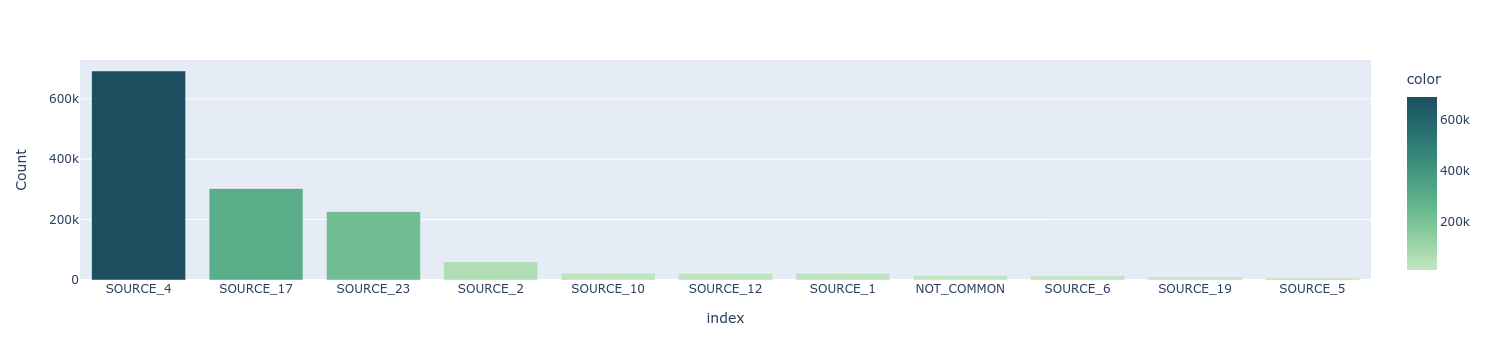

In [13]:
top_sources = data.media_source.value_counts()
top_sources.plot.bar(color = top_sources).update_layout(yaxis_title="Count")

## country_code

In [14]:
print(f'Unique categories {len(data.country_code.unique())}')

Unique categories 224


In [15]:
top_countries = data.country_code.value_counts().iloc[:20]

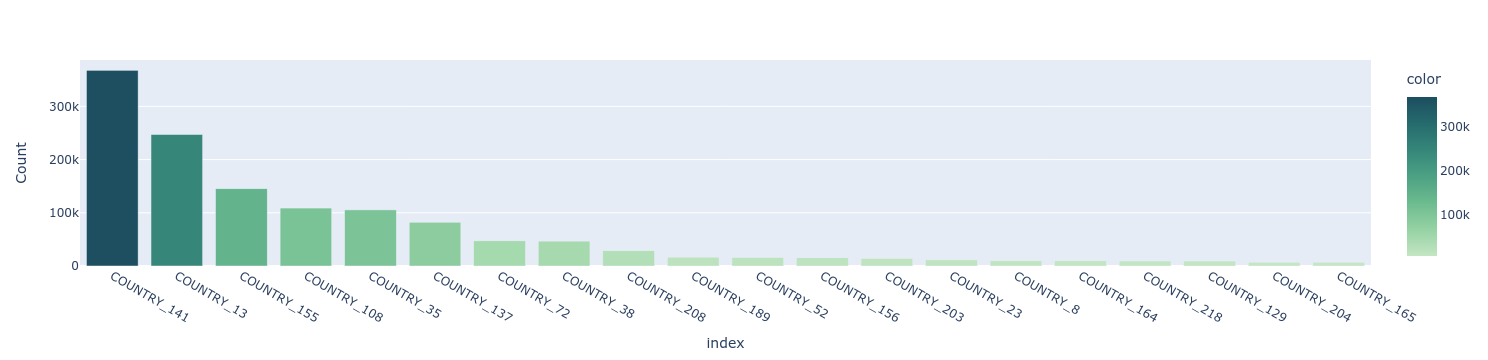

In [16]:
top_countries.plot.bar(color=top_countries).update_layout(yaxis_title="Count",)

Замінимо дані аналогічно з media_source

In [17]:
data['country_code'] = data.country_code.apply(lambda country: country if country in top_countries[:15].index else 'NOT_COMMON')

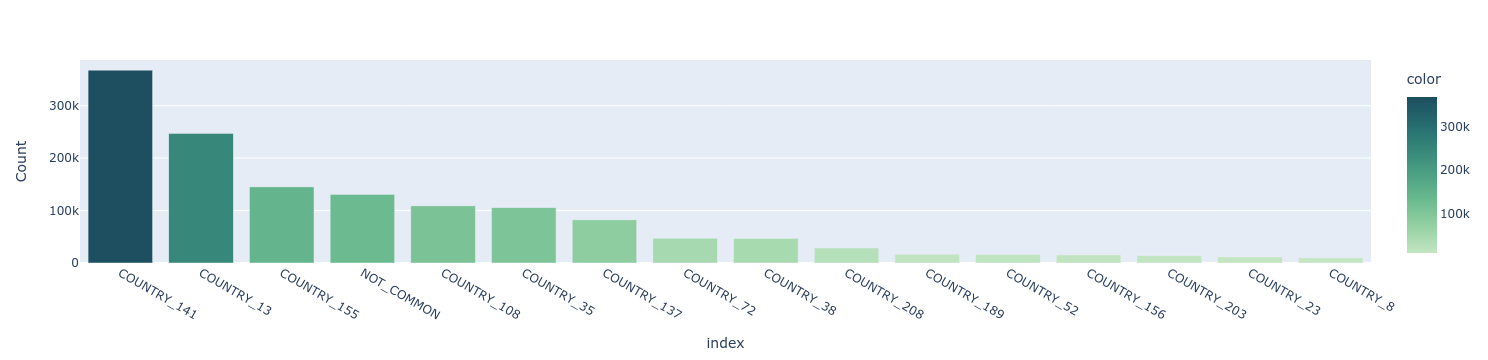

In [18]:
top_countries = data.country_code.value_counts().iloc[:20]
top_countries.plot.bar(color=top_countries).update_layout(yaxis_title="Count")

### platform

<AxesSubplot:xlabel='platform', ylabel='count'>

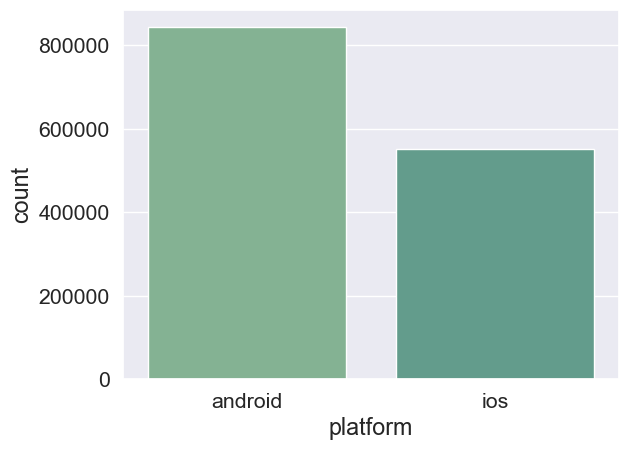

In [19]:
sns.countplot(data=data,x='platform')

Бачимо, що платформа ios генерує більше всього прибутку. На обох платформах основний прибуток скаладають покупки

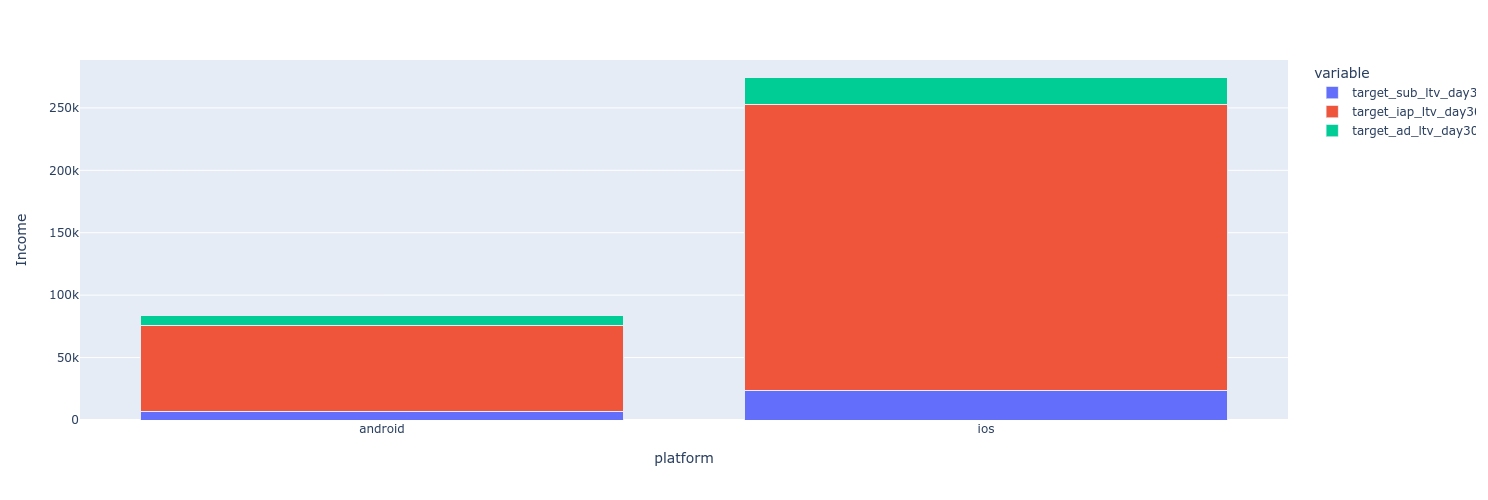

In [20]:
data[['platform','target_sub_ltv_day30','target_iap_ltv_day30','target_ad_ltv_day30']].groupby(by='platform').sum().plot\
.bar(barmode='stack',width=800,height=500)\
.update_layout(yaxis_title="Income",)

## retained

Якщо подивимося на найбільш прибуткових гравців, а саме на retained_day{N}, зрозуміємо, що вони регулярно заходять і ми можемо зробити з цього нову фічу 'active'

In [21]:
data.sort_values(by='target_full_ltv_day30',ascending=False).head(20)

total_sessions_day0  total_sessions_day1  total_sessions_day3  \
88142                15.0000              22.0000              47.0000   
14879                18.0000              21.0000              23.0000   
626878               14.0000              32.0000              55.0000   
1061159               2.0000              11.0000              27.0000   
4381                  2.0000              11.0000              27.0000   
323838               14.0000              47.0000              97.0000   
1377229               4.0000              13.0000              39.0000   
472256                8.0000              11.0000              22.0000   
44787                 5.0000               8.0000              26.0000   
1227660             771.0000             771.0000             771.0000   
702620                2.0000              11.0000              27.0000   
631765                2.0000              11.0000              27.0000   
632844                2.0000              11.0000              27.0000   
168196               17.0000              17.0000              17.0000   
954955                7.0000               8.0000              26.0000   
539891               12.0000              20.0000              23.0000   
779398               26.0000              51.0000              81.0000   
1060942              34.0000              64.0000              96.0000   
329146                3.0000               3.0000              28.0000   
440639                6.0000              14.0000              32.0000   

         total_sessions_day7  chapters_finished_day0  chapters_finished_day1  \
88142                97.0000                      23                      49   
14879                50.0000                      17                      20   
626878               88.0000                      25                      42   
1061159              53.0000                      19                      39   
4381                 53.0000                      19                      39   
323838              189.0000                       6                       7   
1377229             114.0000                      26                      39   
472256               68.0000                      33                      80   
44787                56.0000                      19                      33   
1227660             771.0000                       7                     359   
702620               53.0000                      19                      39   
631765               53.0000                      19                      39   
632844               53.0000                      19                      39   
168196               17.0000                       0                      44   
954955               66.0000                      23                      26   
539891               45.0000                      18                      50   
779398              148.0000                       7                      14   
1060942             135.0000                       7                      12   
329146               79.0000                       0                       0   
440639               66.0000                      41                      55   

         chapters_finished_day3  chapters_finished_day7  chapters_opened_day0  \
88142                        78                     148                    24   
14879                        53                     165                    18   
626878                       90                     123                    26   
1061159                     100                     179                    20   
4381                        100                     179                    20   
323838                       11                      27                     7   
1377229                      80                     143                    27   
472256                      156                     228                    34   
44787                        56             

In [22]:
data['active'] = data[['retained_day1','retained_day3','retained_day7']].sum(axis=1) == 3

In [23]:
print('Active users mean income: ', data[data.active==True].target_full_ltv_day30.mean())
print('Not active users mean income: ', data[data.active==False].target_full_ltv_day30.mean())

Active users mean income:  3.8187079429626465
Not active users mean income:  0.19670803844928741


## install date

<AxesSubplot:xlabel='install_date', ylabel='count'>

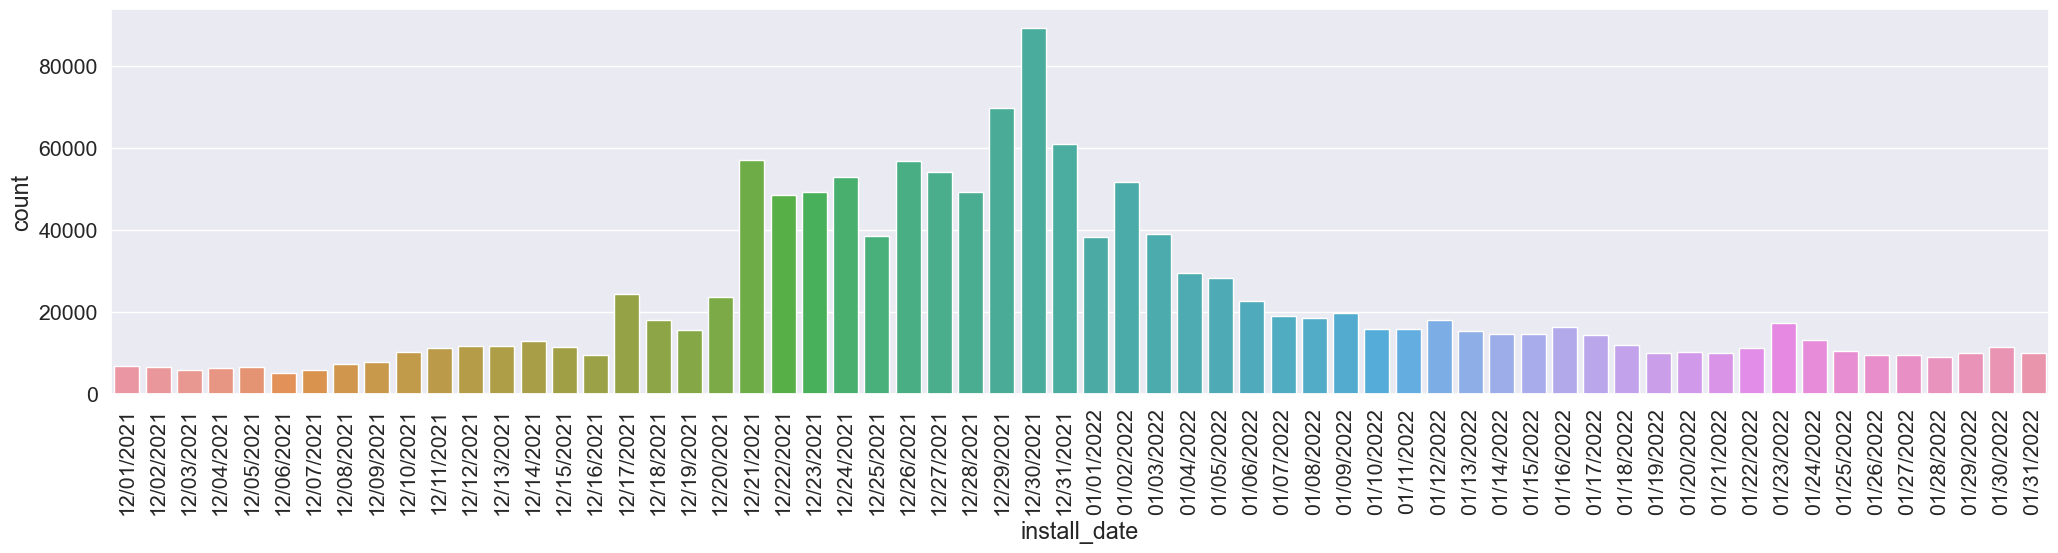

In [24]:
date_sorted = data.sort_values(by=['install_date'])
date_sorted['install_date'] = date_sorted.install_date.dt.strftime('%m/%d/%Y')
plt.figure(figsize = (25,5))
plt.xticks(rotation=90)
sns.countplot(data=date_sorted,x='install_date')


Додамо фічу, яка рахує час після завантаження гри

In [25]:
data['days_since_install'] = (data.install_date.max() - data.install_date).dt.days

## Boxplots

In [26]:
cols = ['total_sessions_day7','chapters_finished_day7','chapters_opened_day7','diamonds_received_day7','tickets_spent_day7']
def compare(df,cols,
           figsize=(15,25)):
    income_data = df[df.target_full_ltv_day30 != 0]
    zero_target_data = df[df.target_full_ltv_day30 == 0]
    rows = len(cols)
    plt.figure(figsize=figsize)
    for row,col in enumerate(cols):
        plt.subplot(rows,3,1+row*3)
        df[col].plot(kind='box',title='All data,\n '+col)
        plt.subplot(rows,3,2+row*3)
        income_data[col].plot(kind='box',title='Non zero target,\n '+col,)
        plt.subplot(rows,3,3+row*3)
        zero_target_data[col].plot(kind='box',title='Zero target,\n '+col,)

    plt.subplots_adjust(wspace=0.4, 
                        hspace=0.4)
    plt.show()

In [27]:
pd.options.plotting.backend = "matplotlib"

Розділимо кожну фічу на три графіки: усі дані, дані без нулів у target_full_ltv_day30 і дані тільки з нулями у target_full_ltv_day30. Бачимо дуже багато дуже великих викидів, що заважають аналізувати 

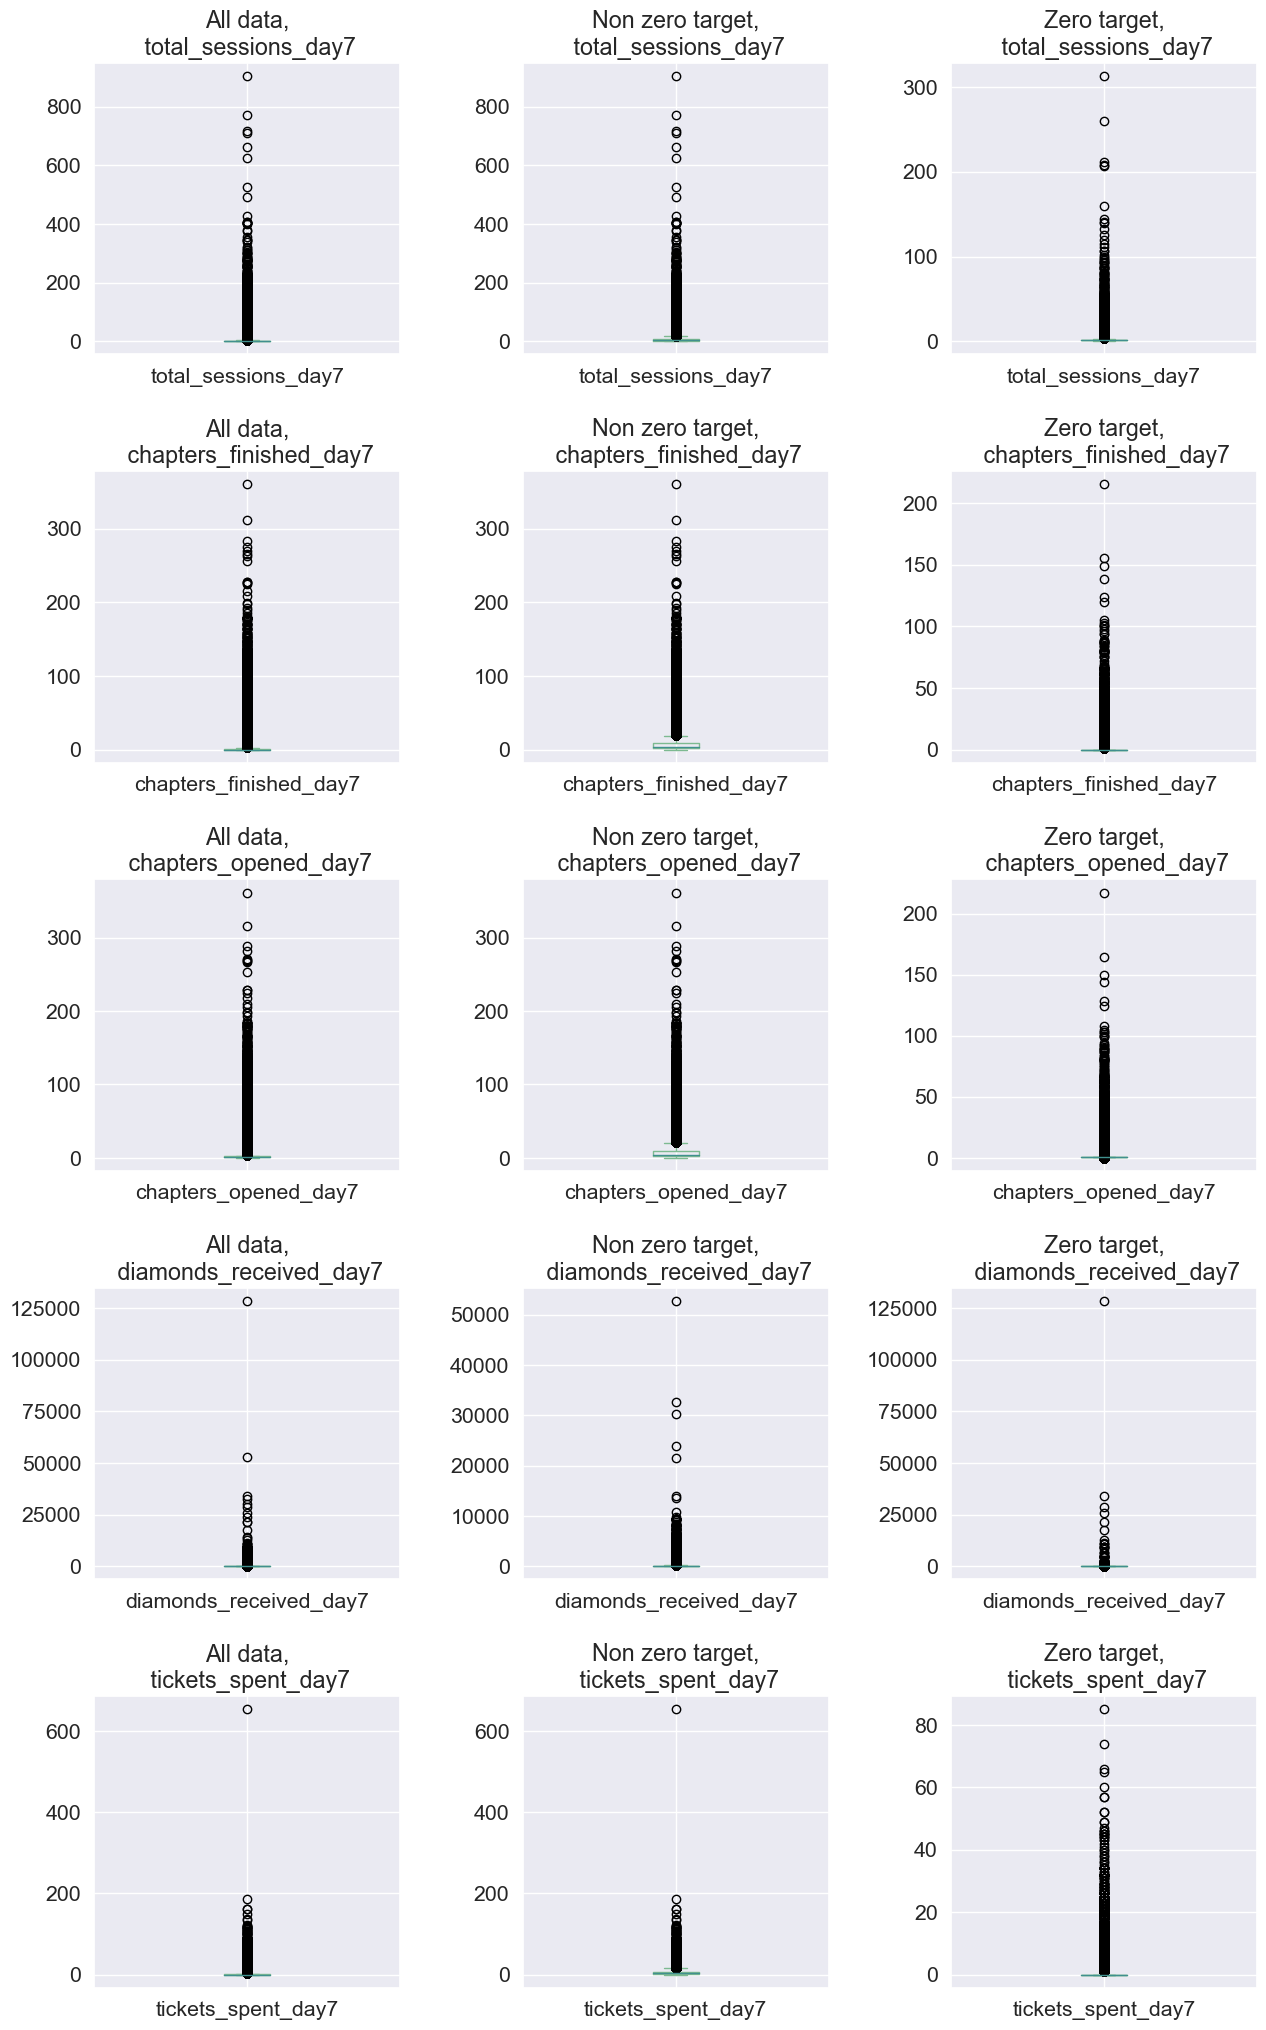

In [28]:
compare(data,cols)

Тому треба знайти ці викиди за допомогою z-score і відфільтрувати

In [29]:
def remove_outliers(dataset,col,threshold=3):
    zscores = zscore(dataset[col])
    size_before= dataset.shape[0]
    # print(dataset[np.abs(zscores)>threshold][col].mean(), np.median(dataset[np.abs(zscores)>threshold][col]))
    dataset = dataset.drop(dataset[np.abs(zscores)>threshold].index)
    print(f'Removed {size_before - dataset.shape[0]} outliers. Total left {dataset.shape[0]}')
    return dataset

In [30]:
data_no_outliers = data.copy()
for col in cols:
    print(col)
    data_no_outliers = remove_outliers(data_no_outliers,col,threshold=3)


total_sessions_day7
Removed 20843 outliers. Total left 1372298
chapters_finished_day7
Removed 38714 outliers. Total left 1333584
chapters_opened_day7
Removed 44265 outliers. Total left 1289319
diamonds_received_day7
Removed 4232 outliers. Total left 1285087
tickets_spent_day7
Removed 46239 outliers. Total left 1238848


Тут ми бачимо, що ті гравці, які відкривають і завершають більше глав, також приносять і більше грошей

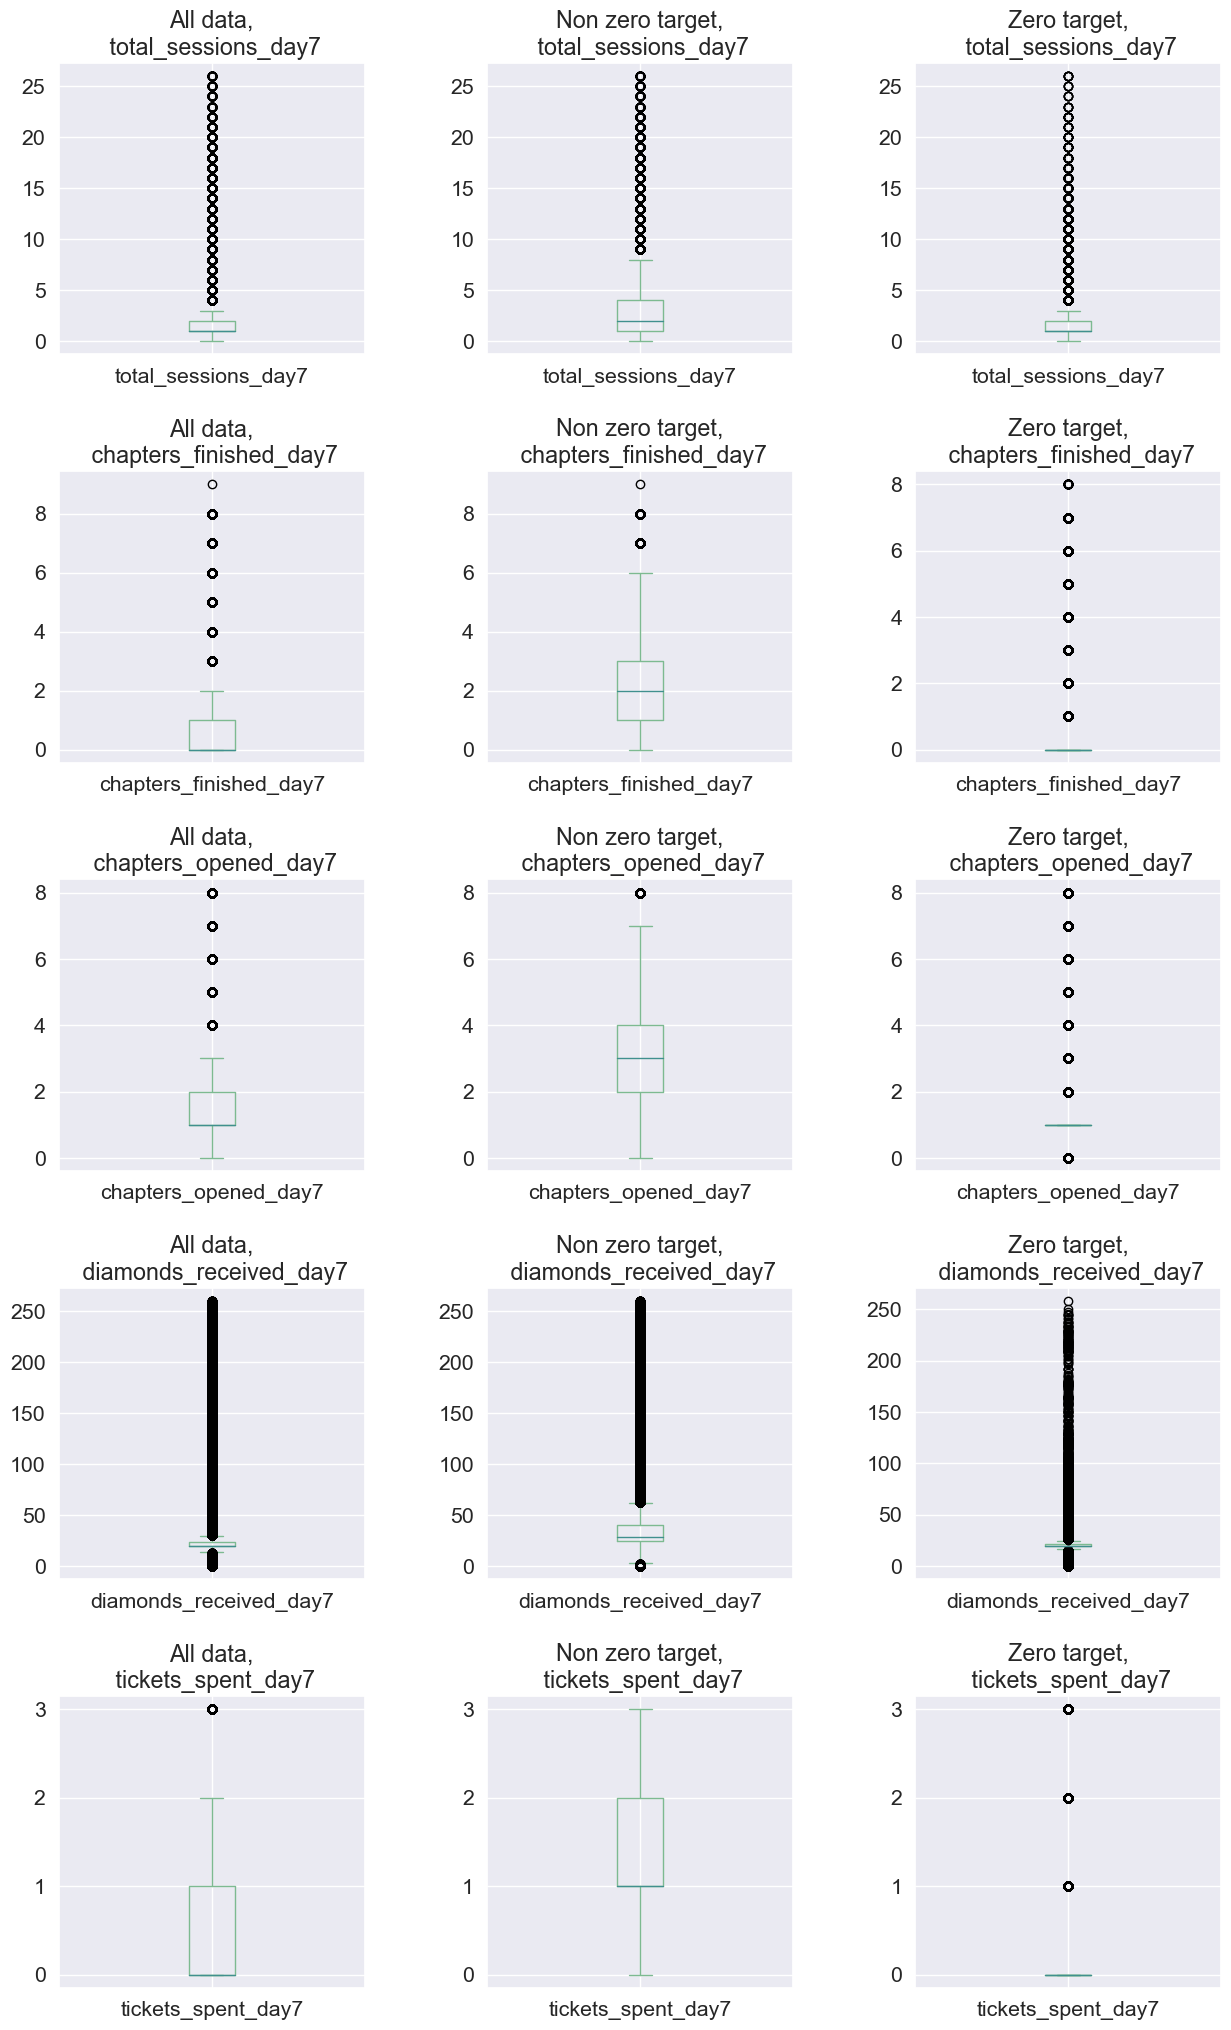

In [31]:
compare(data_no_outliers,cols)

Створимо нові фічі, які показують активність гравця. Цілком логічно, що некативний гравець буде менше платити

In [32]:
data['no_chapters_finished'] = data['chapters_finished_day7']==0
data['no_chapters_closed'] = data['chapters_closed_day7']==0
data['no_chapters_opened'] = data['chapters_opened_day7']==0
data['target_zero'] = data['target_full_ltv_day30']==0
data['afk'] = data['no_chapters_opened'] & data['no_chapters_finished'] & data['no_chapters_closed']

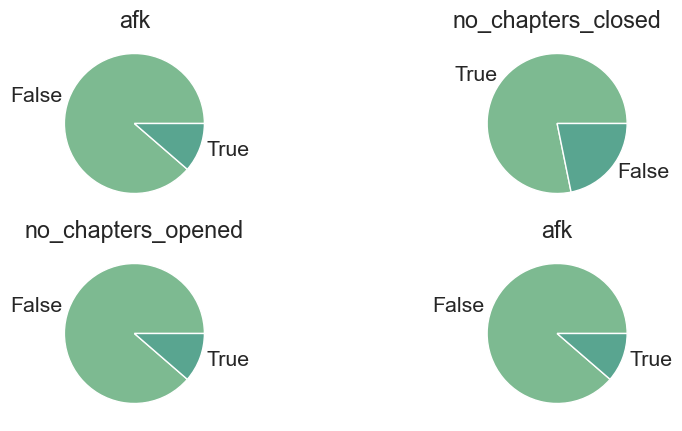

In [33]:
plt.figure(figsize=(10,5))
cols = ['afk','no_chapters_closed','no_chapters_opened','afk']
for i,col in enumerate(cols):
    plt.subplot(2,2,i+1)
    data[col].value_counts().plot.pie(ylabel='',title=col)

Також створимо фічі, що показують нульові витрати гравців

In [34]:
data['diamonds_zero'] = data.diamonds_spent_session9 == 0
data['tickets_zero'] = data.tickets_spent_session9 == 0
data['all_zero'] = data['diamonds_zero'] & data['tickets_zero']

Бачимо, що майже половина гравців не витрачала ні кристали, ні квитки

<AxesSubplot:title={'center':'all_zero'}>

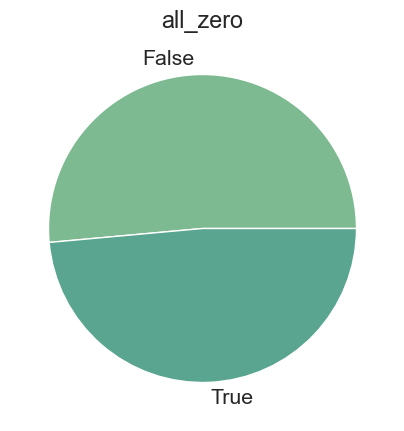

In [35]:
plt.figure(figsize=(5,5))
data['all_zero'].value_counts().plot.pie(ylabel='',title='all_zero')

Гіпотеза підтверджується, гравці, які не витрачають кристали та квитки також і не платять

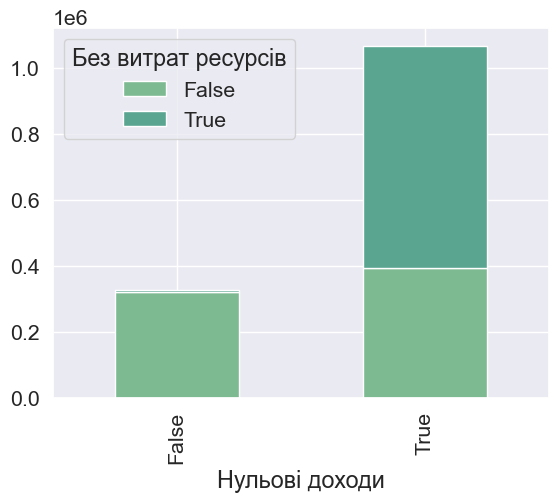

In [36]:
data.groupby(['target_zero','all_zero']).size().unstack().plot.bar(stacked=True,xlabel='Нульові доходи')
plt.legend(title='Без витрат ресурсів')

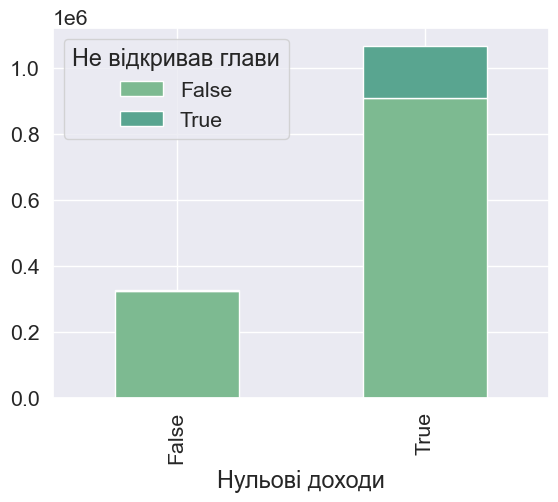

In [37]:
data.groupby(['target_zero','no_chapters_opened']).size().unstack().plot.bar(stacked=True,xlabel='Нульові доходи')
plt.legend(title='Не відкривав глави')

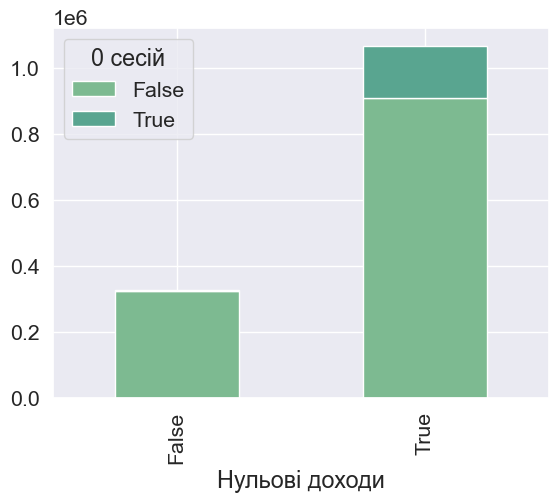

In [38]:
data.groupby(['target_zero','afk']).size().unstack().plot.bar(stacked=True,xlabel='Нульові доходи')
plt.legend(title='0 сесій')

In [39]:
data.head()

total_sessions_day0  total_sessions_day1  total_sessions_day3  \
0               1.0000               1.0000               1.0000   
1               2.0000               2.0000               2.0000   
2               2.0000               2.0000               3.0000   
3               1.0000               1.0000               1.0000   
4               1.0000               1.0000               1.0000   

   total_sessions_day7  chapters_finished_day0  chapters_finished_day1  \
0               1.0000                       1                       1   
1               2.0000                       0                       0   
2               3.0000                       3                       3   
3               1.0000                       2                       2   
4               1.0000                       0                       0   

   chapters_finished_day3  chapters_finished_day7  chapters_opened_day0  \
0                       1                       1                     2   
1                       0                       0                     1   
2                       5                       5                     4   
3                       2                       2                     2   
4                       0                       0                     1   

   chapters_opened_day1  chapters_opened_day3  chapters_opened_day7  \
0                     2                     2                     2   
1                     1                     1                     1   
2                     4                     6                     6   
3                     2                     2                     2   
4                     1                     1                     1   

   chapters_closed_day0  chapters_closed_day1  chapters_closed_day3  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   chapters_closed_day7  diamonds_received_day0  diamonds_received_day1  \
0                     0                      22                      22   
1                     0                      20                      20   
2                     0                      31                      31   
3                     0                      29                      29   
4                     0                      20                      20   

   diamonds_received_day3  diamonds_received_day7  diamonds_spent_day0  \
0                      22                      22                   12   
1                      20                      20                    0   
2                      37                      37                   24   
3                      29                      29                   12   
4                      20                      20                   12   

   diamonds_spent_day1  diamonds_spent_day3  diamonds_spent_day7  \
0                   12                   12                   12   
1                    0                    0                    0   
2                   24                   24                   24   
3                   12                   12                   12   
4                   12                   12                   12   

   tickets_spent_day0  tickets_spent_day1  tickets_spent_day3  \
0                   1                   1                   1   
1                   0                   0                   0   
2                   3                   3                   5   
3                   1                   1                   1   
4                   0                   0                   0   

   tickets_spent_day7  retained_day1  retained_day3  retained_day7  \
0                   1              0              0              0   
1       

In [40]:
# приберемо ці стовпці, бо ми знаємо, що вони прямо залежать від target_full_ltv_day30
corrmat = data.drop(columns=['target_sub_ltv_day30',
 'target_iap_ltv_day30',
 'target_ad_ltv_day30']).corr()

Подивипося на матрицю кореляції

- Бачимо, що кількість витрачених квитків сильно корелює з кількістю завершених глав. Це ми вже знаємо з опису проблеми, але побачити підтвердження теж корисно
- За покупки можна отримати кристали. 

Це лише підтверджує те, що ми вже знаємо, тому подивимося на наближену матрицю кореляції для target_full_ltv_day30

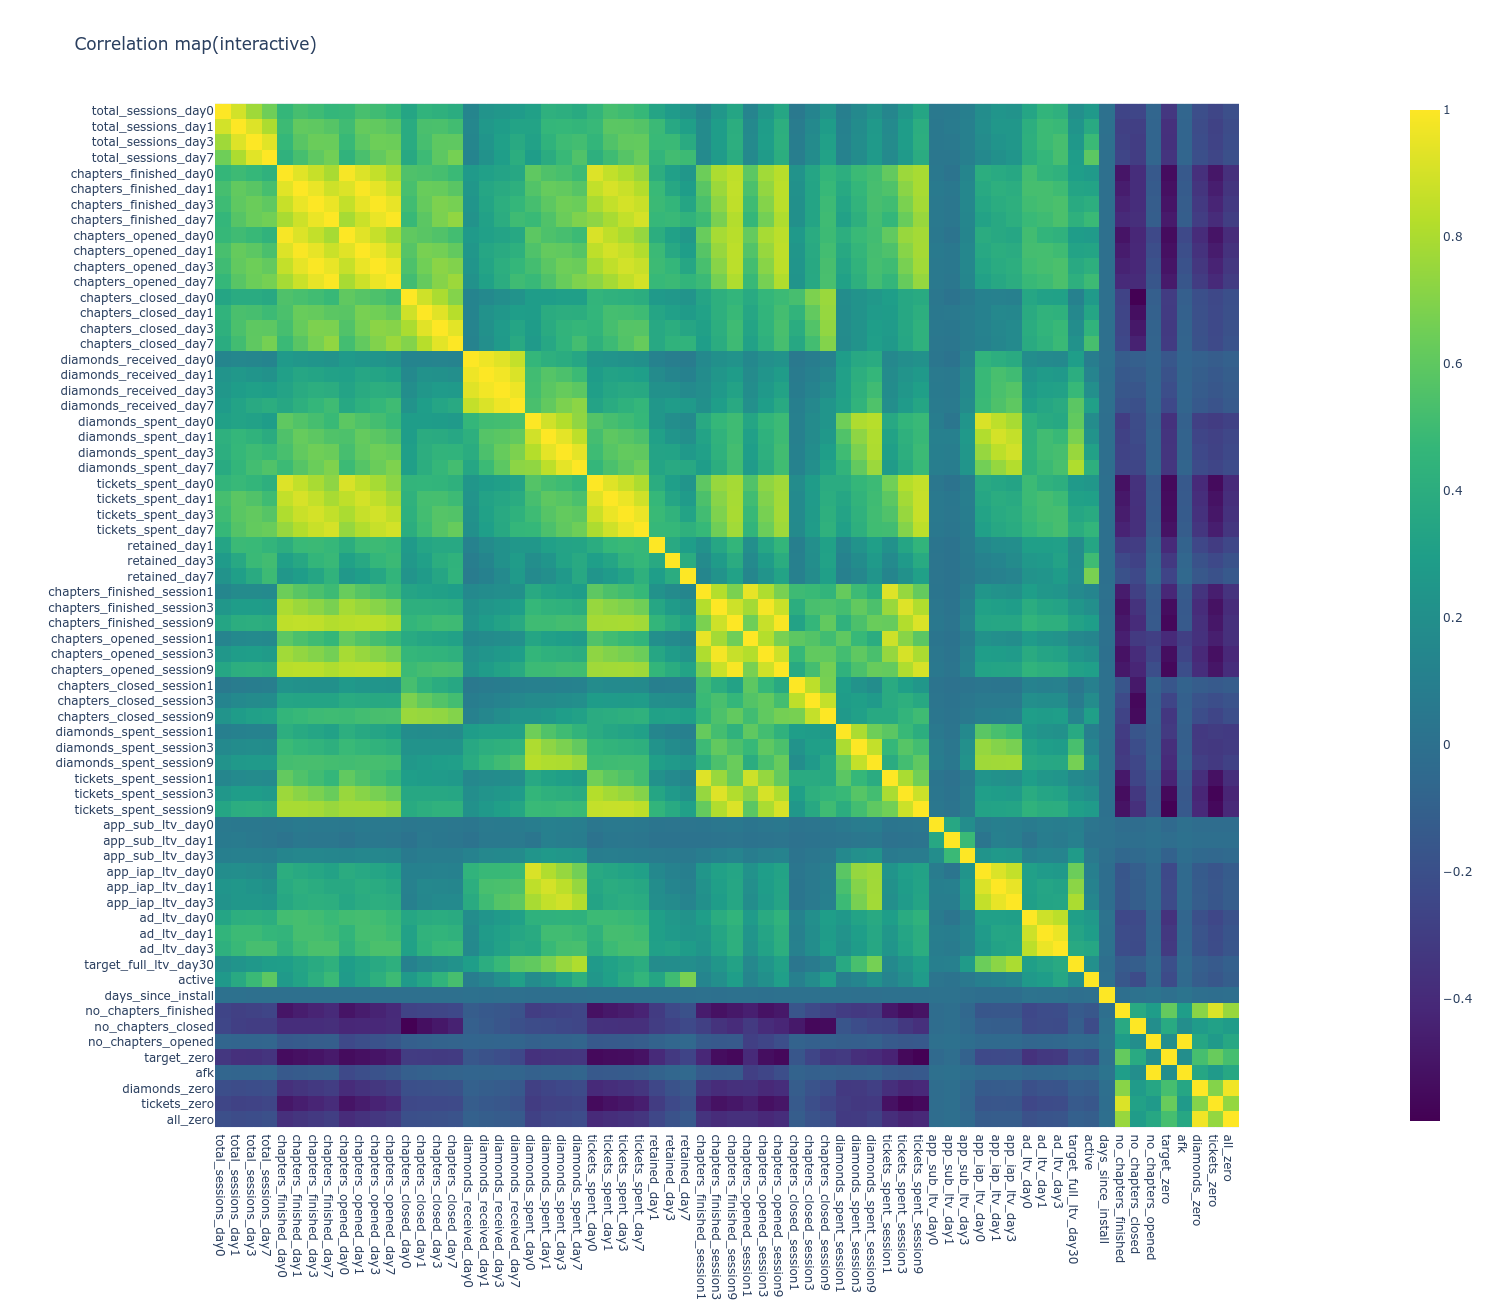

In [41]:
import plotly.express as px
fig = px.imshow(corrmat,width=1300, height=1300,color_continuous_scale='viridis', title='Correlation map(interactive)')
fig.show()

target_full_ltv_day30 дуже сильно корелює з такими фічами:
- кількістю витрачених кристалів diamonds_spent_day{N}
- кількістю пройдених глав chapters_finished_day{N}
- інформацією про покупку app_iap_ltv_day{N}, ad_ltv_day{N}

Скоріш за все, саме ці фічі будуть найважливішими для моделі

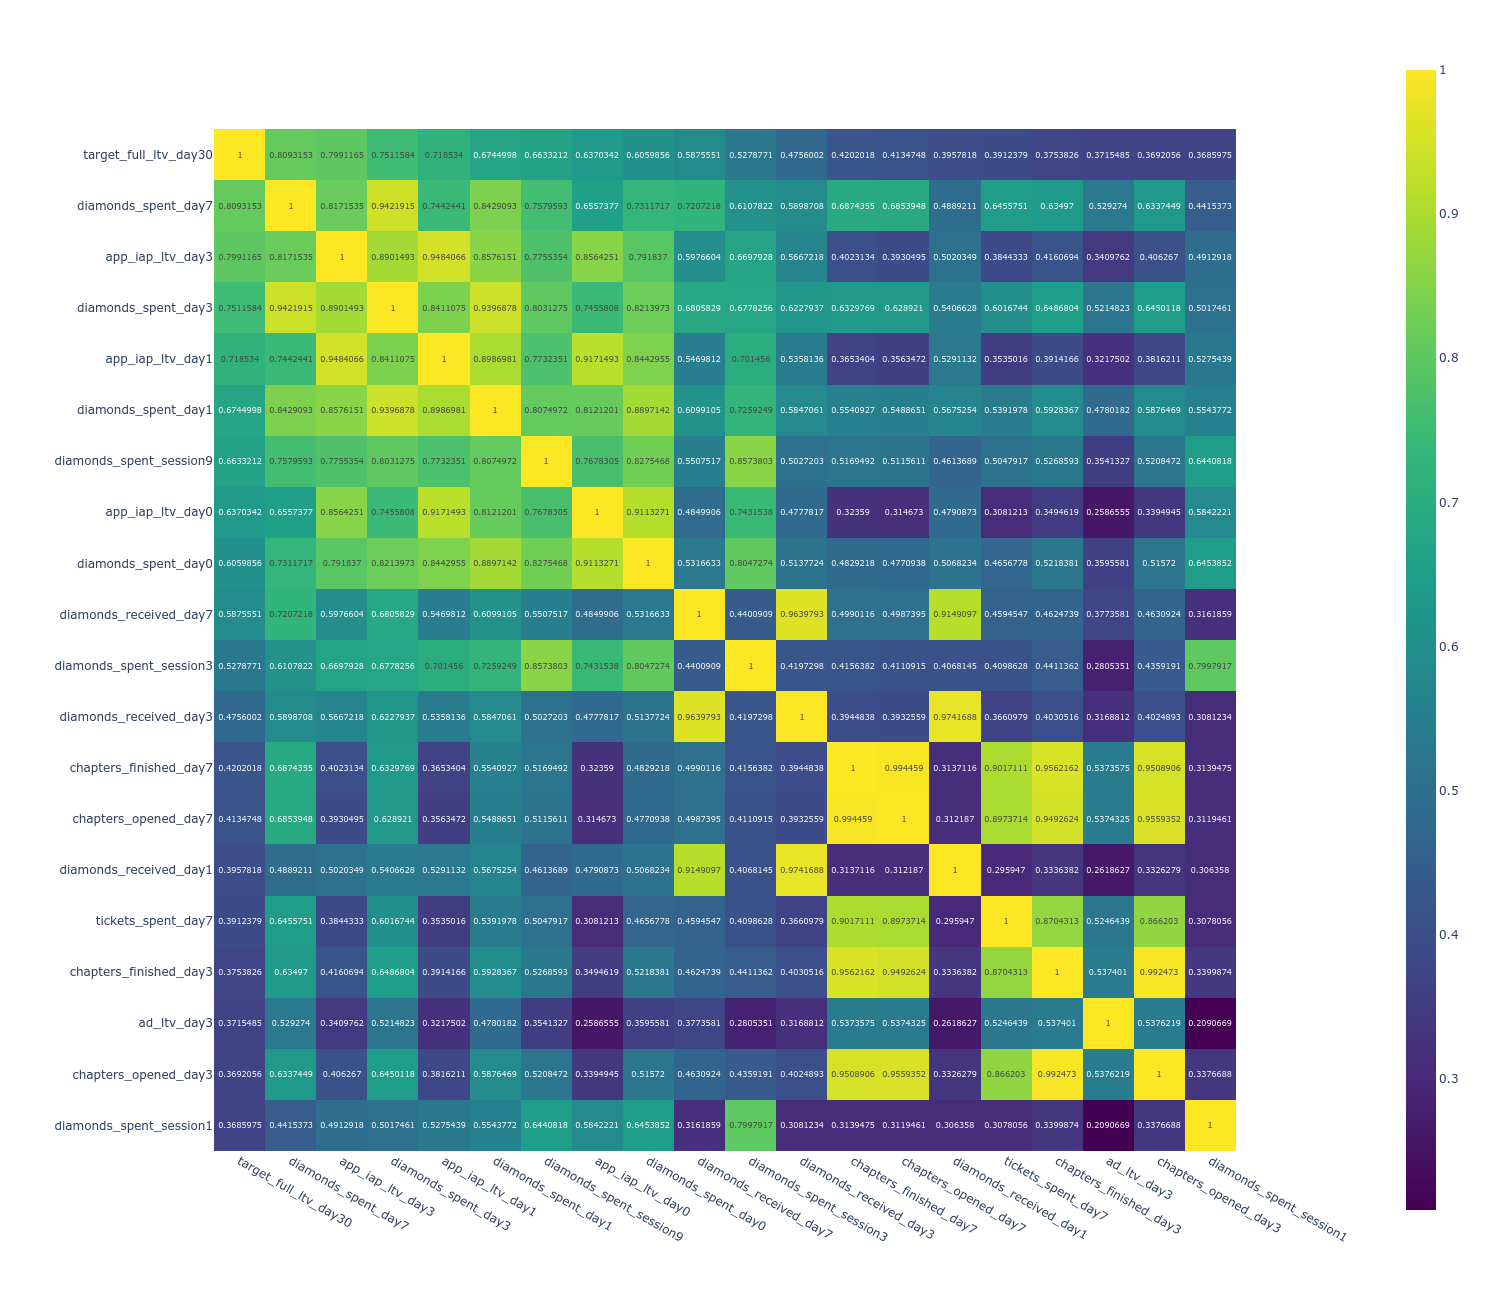

In [42]:
#number of variables for heatmap
k = 20
cols = corrmat.nlargest(k, 'target_full_ltv_day30')['target_full_ltv_day30'].index
cm = np.corrcoef(data[cols].values.T)
fig = px.imshow(cm,width=1300, height=1300,x=cols.values,y=cols.values,text_auto=True,color_continuous_scale='viridis')
fig.show()


In [43]:
drop_columns = [
'target_iap_ltv_day30', 
'target_ad_ltv_day30',
'target_sub_ltv_day30',
'install_date',
'target_zero'
]

def prepare_data(df,drop_columns):
    X_train,X_test = train_test_split(df.drop(columns=drop_columns),shuffle=True,random_state=0,test_size=0.075)   
    print(f'Train size:{X_train.shape[0]}')
    print(f'Test size:{X_test.shape[0]}')
    y_train = X_train.target_full_ltv_day30
    y_test = X_test.target_full_ltv_day30
    
     
    X_train = X_train.drop(columns='target_full_ltv_day30')
    X_test = X_test.drop(columns='target_full_ltv_day30')

    
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = prepare_data(data,drop_columns)


Train size:1288655
Test size:104486


In [44]:

class BoolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X*1
        self.columns = X.columns
        return X
    def get_feature_names_out(self,names=None):
        return self.columns

In [45]:

def get_transformer(df):

    numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64','int32','float32']]
    categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    bool_cols = [cname for cname in df.columns if df[cname].dtype == "bool"]

    # QuantileTransformer повинен зменшити скос даних, що зробить модель більш робастною
    numerical_transformer = Pipeline(steps=[('scaler',QuantileTransformer(output_distribution='normal'))])
    categorical_transformer = Pipeline(steps=[('one hot',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False))])
    bool_transformer = Pipeline(steps=[('bool',BoolTransformer())])

    ct = ColumnTransformer(
        transformers=[
            ('bool',bool_transformer,bool_cols),
            ('num',numerical_transformer,numerical_cols),
            ('cat',categorical_transformer,categorical_cols)
        ],
        remainder='passthrough'
    )
    return ct


ct = get_transformer(X_train)
# Apply preprocessing
ct.fit(X_train)

# Save transformer
dump(ct, 'models/custom_transformer.pkl')

X_train = ct.transform(X_train)
X_test = ct.transform(X_test)



FEATURES = ct.get_feature_names_out()

В умові запропонували 3 метрики: MAPE, RMSE, MAE

- MAPE &mdash; одразу ні. Відбувається ділення на 0, якщо y_true=0, а в наших даних цих нулів просто тони. Тому ця метрика просто не буде працювати правильно і видавати великі числа.
- MAE &mdash; слід задуматися. З одного боку вона не чутлива до викидів, яких якраз в нас багато. Але з іншого боку ці викиди для нас важливі, бо це ті гравці, які створюють основний прибуток.
- RMSE &mdash; ця метрика буде головною. Вона метрика досить чутлива до викидів, а це для нас важливо, як стало зрозумілим у попередньому пункті.


In [46]:
def measure_model(y_true,y_pred):
    print('RMSE:', mean_squared_error(y_true,y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_true,y_pred))
    print('MAE:', mean_absolute_error(y_true,y_pred))

In [47]:
# 10-fold cross validation
FOLDS=10
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=0)

mape_score=0
rmse_score=0
mae_score =0

preds=np.zeros(len(X_test))

lgb_fimp = []
models = []
for fold, (train_idx, val_idx) in tqdm(enumerate(cv.split(X_train, y_train)),total=FOLDS):
    X_train_fold, X_valid_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_valid_fold = y_train[train_idx], y_train[val_idx]

    # Train model
    rg = LGBMRegressor(boosting_type='gbdt', objective='regression',metric='rmse',verbose=-1,random_state=0, n_estimators=400,learning_rate= 0.03, max_depth= 16)
    rg.fit(X_train_fold, y_train_fold,verbose=-1)
   
    # Save feature importances
    fim = pd.DataFrame(index=FEATURES,
             data=rg.feature_importances_,
             columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    # save model to list
    models.append(rg)
    
     # Make predictions and measure metrics
    preds += rg.predict(X_test)
    val_prediction = rg.predict(X_valid_fold)
    rmse_score += mean_squared_error(y_valid_fold,val_prediction)
    mae_score +=mean_absolute_error(y_valid_fold,val_prediction)
    mape_score +=mean_absolute_percentage_error(y_valid_fold,val_prediction)

# Average accuracy    
mape_score=mape_score/FOLDS
rmse_score=rmse_score/FOLDS
mae_score=mae_score/FOLDS

# Print accuracy and time
print('Training set metrics')
print('Average RMSE:', rmse_score)
print('Average MAPE:', mape_score)
print('Average MAE:', mae_score)

preds=preds/(FOLDS)
print('\n')
print('Final test predictions')
measure_model(y_test,preds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.83s/it]

Training set metrics
Average RMSE: 1.030461596386783
Average MAPE: 19533934914041.07
Average MAE: 0.08255804907542491


Final test predictions
RMSE: 0.8830490349819653
MAPE: 18104305938549.684
MAE: 0.08003889284272021


Скоріше за все наша модель буде трохи переоцінювати нульові значення, тому можемо це виправити невеликим обмеженням і ще трохи покращити результат

In [48]:
final_preds = np.where(preds<0.01,0,preds)
print('Final test predictions with threshold')
measure_model(y_test,final_preds)

Final test predictions with threshold
RMSE: 0.8827016930964457
MAPE: 3215449258298.473
MAE: 0.07665175033377267


Ще створимо графік важливості фіч, це корисно для розуміння логіки моделі. Як бачимо їй важливо знати скільки раз користувач грає і його прогрес по главам. Це підштовхує на роздуми, що можливо слід додати інші характеристики активності, які зроблять модель кращою

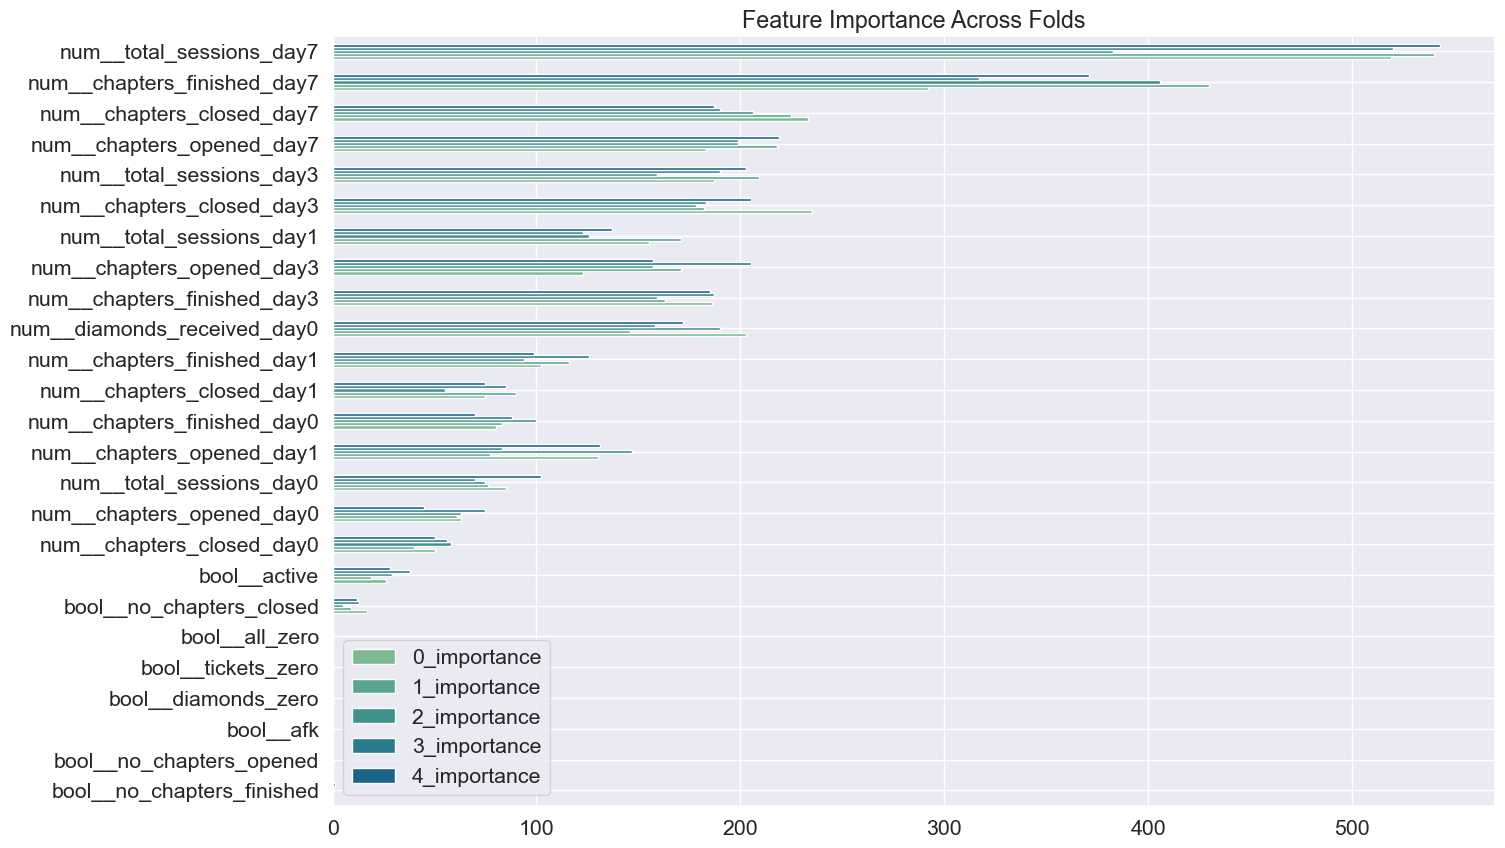

In [49]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1)[:25][[f'{i}_importance' for i in range(5)]]
lgbm_fis_df.sort_values(by='1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

З цією моделлю вже можна прогнозувати сумарні доходи з усіх гравців

In [50]:
pd.DataFrame(data={'pred':final_preds,'true':y_test}).sum()

pred   26827.3384
true   26992.1699
dtype: float64

Можемо зберігти нашу модель у файл

In [51]:
for i,model in enumerate(models):
    model.booster_.save_model(f'models/lgbm_regressor_fold_{i}.txt')